# SPIB Workflow Tutorial

This notebook demonstrates how to use `geom2vec` to:

- Train a VAMPNet on precomputed geom2vec embeddings (as in `5_vamp_workflow.ipynb`).
- Cluster the resulting collective variables (CVs) with K-means to obtain initial discrete labels.
- Construct a SPIB dataset using `geom2vec.data.Preprocessing.create_spib_dataset`.
- Train a `SPIBModel` to learn a low-dimensional information bottleneck representation.


In [1]:
from pathlib import Path
import re

import numpy as np
import torch
from sklearn.cluster import MiniBatchKMeans

from geom2vec.data import Preprocessing
from geom2vec.models.downstream import Lobe, VAMPWorkflow, SPIBModel
from geom2vec.models.downstream.vamp.vampnet import VAMPNetConfig
from geom2vec.models.downstream.vamp.workflow import build_trajectories_from_embedding_dir


/project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/libpyg.so)
  import torch_geometric.typing
/project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/libpyg.so)
  import torch_geometric.typing


## Load Precomputed Embeddings

Point `embedding_dir` to the folder produced by the inference notebook (e.g.
`4_infer_mdanalysis.ipynb`). Each `.pt` file should contain a tensor of shape
`(num_frames, num_tokens, 4, hidden_channels)`


In [2]:
embedding_dir = Path("/project/dinner/zpengmei/geom2vec_02/examples/_artifacts/chignolin_infer")
lag_time = 1
train_fraction = 0.8  # fraction of data used for training when multiple trajectories exist

trajectories, graph_trajectories, ca_trajectories = build_trajectories_from_embedding_dir(embedding_dir)
print(f"Loaded {len(graph_trajectories)} trajectories with shapes: {[traj.shape for traj in graph_trajectories]}")

/project/dinner/zpengmei/apps/geom2vec/src/geom2vec/models/downstream/vamp/workflow.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_trajectories = [torch.load(pa

Loaded 54 trajectories with shapes: [torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), torch.Size([1000, 10, 4, 256]), tor

/project/dinner/zpengmei/apps/geom2vec/src/geom2vec/models/downstream/vamp/workflow.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ca_trajectories: List[torch.Tensor]

## Configure and Train VAMPNet

We first set up a `Lobe` and a `VAMPWorkflow` (as in `5_vamp_workflow.ipynb`) to learn slow CVs from the embeddings.


In [4]:
hidden_channels = graph_trajectories[0].shape[-1]
num_tokens = graph_trajectories[0].shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lobe = Lobe(
    input_channels=hidden_channels,
    hidden_channels=128,
    output_channels=3,
    num_mlp_layers=2,
    num_tokens=num_tokens,
    num_mixer_layers=3,
    equi_rep=True,
    merger=False,
    merger_window=1,
    equi_backend='torch',
).cuda()

lobe = lobe.to(device)


config = VAMPNetConfig(
    device='cuda',  # change to 'cuda' once FlashAttention kernels are available
    train_patience=20,
    valid_patience=20,
    train_valid_interval=5,
    learning_rate=2e-4,
    score_method='vamp-2',
    optimizer='AdamAtan2'
)

workflow = VAMPWorkflow(
    lobe=lobe.to(device),
    trajectories=trajectories,
    lag_time=lag_time,
    config=config,
    train_fraction=train_fraction,
    batch_size=2000,
    seed=0,
    concat_trajectories=True,
)
workflow


In [5]:
vamp = workflow.fit(n_epochs=10, progress=lambda iterable, **_: iterable)
print("Training batches:", len(workflow.train_loader))


best val: -inf: 0it [00:00, ?it/s]

Training patience reached at epoch 7
Training batches: 22


## Compute CVs and Initial Discrete Labels

We transform the original trajectories through the trained VAMPNet to obtain CV trajectories,
then apply `MiniBatchKMeans` to define initial discrete state labels for SPIB.


In [6]:
# Obtain CVs for all trajectories using the trained VAMPNet
cvs = workflow.transform(trajectories, instantaneous=True, return_cv=True, batch_size=512)

# Ensure we always work with a list of arrays
if isinstance(cvs, np.ndarray):
    cvs_list = [cvs]
else:
    cvs_list = list(cvs)

# Concatenate CVs across all trajectories for clustering
cvs_concat = np.concatenate(cvs_list, axis=0)
print("Total CV frames:", cvs_concat.shape[0], "dim:", cvs_concat.shape[1])

n_clusters = 50  # number of discrete states for SPIB
kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, random_state=0, batch_size=4096)
cluster_labels = kmeans.fit_predict(cvs_concat)

# Split cluster labels back into trajectory-wise arrays
labels_per_traj = []
offset = 0
for traj_cvs in cvs_list:
    length = traj_cvs.shape[0]
    labels = cluster_labels[offset:offset + length]
    labels_per_traj.append(np.asarray(labels, dtype=np.int64))
    offset += length

print("Created labels for", len(labels_per_traj), "trajectories.")


Total CV frames: 53475 dim: 3
Created labels for 54 trajectories.


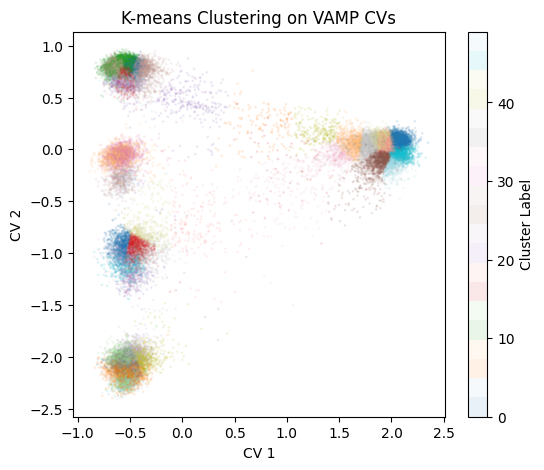

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(cvs_concat[:,0], cvs_concat[:,1], s=1, alpha=0.1, c=cluster_labels, cmap='tab20')
plt.xlabel("CV 1")
plt.ylabel("CV 2")
plt.title("K-means Clustering on VAMP CVs")
plt.colorbar(label="Cluster Label")
plt.show()

## Build SPIB Datasets

We now flatten the original geom2vec embeddings per frame, pair them with the K-means labels,
and use `Preprocessing.create_spib_dataset` to construct train and validation datasets for `SPIBModel`.


In [10]:
preprocess = Preprocessing(dtype=torch.float32, backend="none")
lag_time = 1

train_dataset, test_dataset = preprocess.create_spib_train_test_datasets(
    data_list=graph_trajectories,
    label_list=labels_per_traj,
    train_fraction=train_fraction,
    lag_time=lag_time,
    output_dim=n_clusters,
)

len(train_dataset), len(test_dataset)


(42726, 10641)

## Train the SPIB Model

We reuse the `Lobe` architecture as an encoder: flattened embeddings are reshaped back to
token/scalar/vector form and passed through a `Lobe` head to produce the features consumed by `SPIBModel`.


In [11]:
hidden_dim_spib = 64
lag_time = 1
# Lobe used as SPIB encoder (separate from the VAMP lobe)
spib_lobe = Lobe(
    input_channels=hidden_channels,
    hidden_channels=hidden_channels,
    output_channels=hidden_dim_spib,
    num_mlp_layers=2,
    num_tokens=num_tokens,
    equi_rep=True,
    merger=False,
    merger_window=2,
    equi_backend="torch",
).to(device)

spib = SPIBModel.from_lobe(
    lobe=spib_lobe,
    num_tokens=num_tokens,
    hidden_channels=hidden_channels,
    output_dim=n_clusters,
    lag_time=lag_time,
    device=device,
    optimizer='AdamAtan2',
)

_ = spib.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=2048,
    tolerance=0.001,
    patience=5,
    refinements=5,
    max_epochs_per_refinement=10,
)


Epoch 1:	Time 6.31 s
Loss (train): 3.868170	KL loss (train): 0.349387
Reconstruction loss (train): 3.867821
Loss (test): 3.770453	KL loss (test): 1.201499
Reconstruction loss (test): 3.769251
State population:
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 9.8677623e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2919534e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.0426439e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Relative state population change=2.015223
relative change in state population: 

## Transform Data with SPIB

Finally, we use the trained SPIB model to obtain discrete labels and latent variables,
which can be further analyzed or visualized.


In [12]:
# Concatenate all graph-shaped trajectories for a simple demonstration
all_data = np.concatenate(
    [traj.detach().cpu().numpy().astype(np.float32) for traj in graph_trajectories],
    axis=0,
)
all_data_tensor = torch.from_numpy(all_data).to(device=device, dtype=torch.float32)

labels, all_prediction, z_mean, z_logvar = spib.transform(all_data_tensor, batch_size=2048, to_numpy=True)

print("SPIB latent mean shape:", z_mean.shape)
print("Unique SPIB labels:", np.unique(labels))


SPIB latent mean shape: (53475, 2)
Unique SPIB labels: [0 1 2 3 4 5 6 7 8]


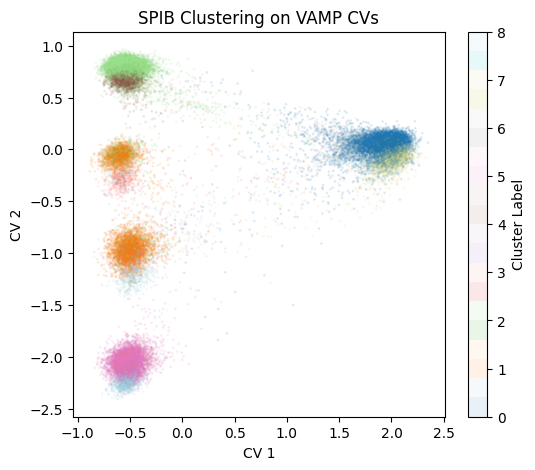

In [13]:
# plot labels on VAMP CV scatter plot
plt.figure(figsize=(6,5))
plt.scatter(cvs_concat[:,0], cvs_concat[:,1], s=1, alpha=0.1, c=labels, cmap='tab20')
plt.xlabel("CV 1")
plt.ylabel("CV 2")
plt.title("SPIB Clustering on VAMP CVs")
plt.colorbar(label="Cluster Label")
plt.show()